In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import keras
from tensorflow.keras.models  import Model,Sequential
from keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout,TimeDistributed,Masking
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
from clr_callback import *
import numpy.ma as ma
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Output labels to to classify dance sequence
LABELS = ["gojjam","guragingna","shoa"]
#dataset path
pathDS = "../dataset/data/"
#number of feautres
features = 36 
#number of labels
classes = 3
#batchSize = 
batchSize = 100

In [37]:
#load training data
x = []
y = []

def loadTrainingXY(data):
    sequenceSize = 50
    
    prevStep = 0
    currentArray = []
    
    for i in range(len(data)):
        if(i != 0):
            prevStep = data[i-1][36]
        currentStep = data[i][36]
    
        if( i != 0 and currentStep <= prevStep):
            
            if(len(currentArray) >= 20):
            
                currentArray = np.array(currentArray).astype(np.float32)
                
                #normalize data
                '''for inorm in range(36):
                    
                    temp = currentArray[:,inorm]
                    maxV = np.nanmax(temp)
                    minV = np.nanmin(temp)
                    
                    if(str(maxV) != str('nan') and str(minV) != str('nan')):
                        tempV = (temp-np.nanmin(temp))/(np.nanmax(temp)-np.nanmin(temp))
                        currentArray[:,inorm] = tempV'''
                        
                
                currentArray = np.where(np.isnan(currentArray), ma.array(currentArray, mask=np.isnan(currentArray)).mean(axis=0), currentArray)
               
            '''if(prevStep >=5):
            
                x.append(np.array(currentArray).astype(np.float32))
                y.append(LABELS.index(data[i-1][37]))'''
            if(len(currentArray) >= sequenceSize):

                nI = sequenceSize
                pI = 0
                for j in range(len(currentArray)// sequenceSize):
                    x.append(np.array(currentArray[pI:nI]).astype(np.float32))
                    y.append(LABELS.index(data[i-1][37]))
                    
                    nI += sequenceSize
                    pI += sequenceSize 
            
            else:
                if(len(currentArray) >= 20 and len(currentArray) < sequenceSize):
                    padding = np.zeros((36,), dtype=np.float32)
                    lengArray = len(currentArray)
                    for ip in range(sequenceSize + 1):
                        
                        if(lengArray >= ip):
                            continue
                        else:
                            
                            currentArray = np.append(currentArray,[padding],axis=0)
                    print(currentArray)  
                    x.append(np.array(currentArray).astype(np.float32))
                    y.append(LABELS.index(data[i-1][37]))                  
    
            currentArray = []
            currentArray.clear()

        currentArray.append(np.array(data[i][:36]).astype(np.float32)) 

In [38]:
csvFile = [csv for csv in os.listdir(pathDS)]
pdList = []
for file in csvFile:
    
    data=pd.read_csv(pathDS+str(file),header=None)
    pdList.append(data)

# Stack the DataFrames on top of each other
data = pd.concat(pdList, axis=0)
data.iloc[:,0:36] = data.iloc[:,0:36].replace(0, np.nan)
data.iloc[:,0:36] = data.iloc[:,0:36].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
testDD = loadTrainingXY(data.values)
    

[[-1.09934199 -1.36711502 -1.10638475 ... -1.53988802 -1.09791541
  -1.31076026]
 [-1.09934199 -1.36711502 -1.10638475 ... -1.53988802 -1.09791541
  -1.31076026]
 [-1.09934199 -1.57687306 -1.10638475 ... -1.5704807  -1.10483372
  -1.4978565 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[-0.03096737 -0.91763365 -0.04697081 ... -0.86685008 -0.06708563
  -0.8430199 ]
 [-0.03096737 -0.91763365 -0.04697081 ... -0.86685008 -0.06708563
  -0.8430199 ]
 [-0.03096737 -1.09742618 -0.08136737 ... -1.08099854 -0.06708563
  -0.87420261]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 0.89265966 -1.09742618  0.92989141 ... -1.08099854  0.8945609

[[-1.85754335 -0.88766819 -1.80807459 ... -0.83625746 -1.91427732
  -0.8430199 ]
 [-1.85065055 -0.88766819 -1.80807459 ... -0.86685008 -1.91344696
  -0.71329994]
 [-1.84375787 -0.88766819 -1.80807459 ... -0.86685008 -1.91344696
  -0.71329994]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[-0.72713405 -0.64794481 -0.78305715 ... -0.622109   -0.79725679
  -0.6130476 ]
 [-0.72713405 -0.64794481 -0.74178129 ... -0.622109   -0.79725679
  -0.6130476 ]
 [-0.72713405 -0.64794481 -0.74178129 ... -0.622109   -0.79725679
  -0.6130476 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[-0.02407463 -0.61797935  0.02182231 ... -0.61446091 -0.0255757

[[ 0.52045178 -1.09742618  0.71663278 ... -1.02363729  0.61782813
  -0.87420261]
 [ 0.56180823 -1.12739158  0.70975345 ... -1.02363729  0.63166475
  -1.03011608]
 [ 0.56870097 -1.1573571   0.71663278 ... -1.02363729  0.68009305
  -1.06129873]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 1.32000959 -0.88766819  1.51463294 ... -1.28834862  1.37192512
  -0.8430199 ]
 [ 1.32690227 -1.09742618  1.52151227 ... -1.28834862  1.37884343
  -1.06129873]
 [ 1.31311679 -1.30718422  1.51463294 ... -1.28834862  1.32349682
  -1.31076026]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[-1.69211757 -0.64794481 -1.53978145 ... -0.84849443 -1.7067277

[[-1.20962584e+00  9.70188320e-01 -1.27836752e+00 ...  1.06048596e+00
  -1.88279896e+00  4.71930951e-04]
 [-1.20273304e+00  1.20991182e+00 -1.27836752e+00 ...  1.09107864e+00
  -1.88279896e+00  4.71930951e-04]
 [-1.20962584e+00  1.26984262e+00 -1.31276417e+00 ...  1.30522704e+00
  -1.88279896e+00  4.71930951e-04]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
[[-0.34803337  0.55067235 -0.46660882 ...  0.60159647 -1.00671942
  -0.62757579]
 [-0.34803337  0.73046494 -0.46660882 ...  0.81574494 -1.00671942
  -0.62757579]
 [-0.35492611  0.97018832 -0.46660882 ...  1.0298934  -1.00671942
  -0.62757579]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  

[[-1.85065055 -0.37825593 -1.85622978 ... -0.37736788 -1.85893071
  -0.31291413]
 [-1.85065055 -0.16849793 -1.85622978 ... -0.16321944 -1.85893071
  -0.09463529]
 [-1.85065055  0.07122549 -1.80807459 ...  0.11211429 -1.85893071
   0.15482627]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[-0.83052516 -0.3482905  -0.83809161 ... -0.34677526 -0.87652916
  -0.31291413]
 [-0.83052516 -0.16849793 -0.83809161 ... -0.1326268  -0.87652916
  -0.09463529]
 [-0.83052516  0.07122549 -0.83809161 ...  0.11211429 -0.84193754
   0.15482627]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 0.03106728 -0.61797935  0.02182231 ... -0.59151632  0.0228525

[[ 0.94090885 -0.61797935  1.15002942 ...  0.          0.9014793
  -0.37527952]
 [ 0.94780159 -0.64794481  1.19818461 ...  0.          0.94298923
  -0.56237566]
 [ 0.94780159 -0.64794481  1.19818461 ...  0.          0.94990754
  -0.59355837]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[-0.72713405 -0.82773733 -1.01007438 ... -0.622109    0.
   0.        ]
 [-0.77538323 -0.67791021 -1.04447103 ... -0.83625746  0.
   0.        ]
 [-0.77538323 -0.82773733 -1.05135036 ... -0.83625746  0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[-0.1757149   0.31094891 -0.19143635 ...  0.35685536 -0.14318717
   0.43547049]
 [-0.182

[[-0.72713405  1.23987722 -0.5629192  ...  0.84633756 -0.29539022
   0.59138393]
 [-0.72713405  1.23987722 -0.5629192  ...  0.81574494 -0.29539022
   0.62256664]
 [-0.72713405  1.23987722 -0.52164328 ...  0.8395391  -0.29539022
   0.43547049]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[1.21661842 0.8203612  0.4964948  ... 0.35685536 0.         0.        ]
 [1.16836929 1.00015378 0.44146031 ... 0.35685536 0.         0.        ]
 [1.15458381 1.00015378 0.40018445 ... 0.38744801 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[-0.98905814  1.23987722 -0.95503992 ...  1.06048596 -1.00105894
   1.12148976]
 [-0.99

[[ 0.46530986 -0.40822136  0.23508096 ... -0.31618261  0.22093502
   0.27135104]
 [ 0.36191878 -0.37825593  0.18004647 ... -0.16321944  0.22093502
   0.27135104]
 [ 0.18960029  0.04126007  0.18692578 ... -0.10203417  0.30650371
  -0.09463529]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[-1.09934199 -0.19846337 -1.21645379 ... -0.37736788  0.
   0.        ]
 [-1.09934199 -0.16849793 -1.21645379 ... -0.34677526  0.
   0.        ]
 [-1.09934199 -0.16849793 -1.22333312 ... -0.34677526  0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 0.23784946 -0.40822136  0.06997748 ... -0.5609237   0.
   0.        ]
 [ 0.23784946 -

[[ 0.12756564 -1.54690766  0.0768568  ... -1.78462911  0.13354568
  -1.74731803]
 [ 0.12756564 -1.54690766  0.0768568  ... -1.5704807   0.13354568
  -1.56022191]
 [ 0.13445836 -1.36711502  0.0768568  ... -1.53988802  0.14046399
  -1.52903914]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[ 0.99605078 -1.54690766  0.98492593 ... -1.5704807   1.00525415
  -1.56022191]
 [ 0.99605078 -1.36711502  0.98492593 ... -1.53988802  1.00525415
  -1.52903914]
 [ 0.99605078 -1.33714962  0.98492593 ... -1.3563323   1.00525415
  -1.34194303]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[-0.83052516 -0.64794481 -0.84497094 ... -0.622109   -0.8350192

In [39]:
data

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,-1.051093,-2.056320,-1.003195,-1.755186,-1.020822,-1.724891,-1.035060,-1.451960,-1.293697,-1.665984,...,-1.065819,-2.112631,-1.033526,-2.106905,-1.052420,-2.029370,-1.049487,-2.059145,0.0,shoa
1,-1.051093,-2.056320,-1.003195,-1.755186,-1.020822,-1.724891,-1.041912,-1.451960,-1.293697,-1.665984,...,-1.065819,-2.112631,-1.033526,-2.106905,-1.052420,-2.029370,-1.049487,-2.059145,1.0,shoa
2,-1.044200,-2.026354,-1.003195,-1.723654,-1.020822,-1.724891,-1.083027,-1.451960,-1.334737,-1.665984,...,-1.065819,-1.903764,-1.026627,-2.076879,-1.052420,-1.845814,-1.049487,-2.059145,2.0,shoa
3,-1.044200,-1.996389,-1.044471,-1.723654,-1.055095,-1.724891,-1.089879,-1.451960,-1.341577,-1.665984,...,-1.065819,-1.903764,-1.026627,-1.896725,-1.045451,-1.815222,-1.049487,-1.996780,3.0,shoa
4,-1.044200,-1.996389,-1.051350,-1.723654,-1.068804,-1.535786,-1.096732,-1.451960,-1.348416,-1.665984,...,-1.065819,-1.903764,-1.026627,-1.896725,-1.045451,-1.815222,-1.049487,-1.809683,4.0,shoa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51924,0.885767,-0.887668,0.867978,-1.250674,0.864180,-1.252129,0.897340,-1.451960,0.949797,-1.665984,...,0.881611,-0.919104,0.863819,-0.935903,0.954688,-0.866850,0.839214,-0.843020,50.0,guragingna
51925,0.885767,-0.887668,0.867978,-1.250674,0.864180,-1.252129,0.890487,-1.483099,NaN,NaN,...,0.874705,-0.948942,0.863819,-0.935903,0.947719,-0.866850,0.832296,-0.874203,51.0,guragingna
51926,0.885767,-0.887668,0.833581,-1.250674,0.864180,-1.252129,0.897340,-1.669938,0.901918,-1.878036,...,0.874705,-0.919104,0.856919,-0.905877,0.912873,-0.866850,0.797704,-0.843020,52.0,guragingna
51927,0.844411,-0.887668,0.826702,-1.219142,0.864180,-1.220611,0.945307,-1.451960,0.942957,-1.665984,...,0.874705,-0.769914,0.856919,-0.905877,0.905904,-0.836257,0.790786,-0.843020,53.0,guragingna


In [40]:
xDataSet = np.array(x).astype(np.float32)
'''
le = LabelEncoder()
le.fit(y)

yDataSet = le.transform(y)
'''
yDataSet = np.array(y).astype(np.float32)
#test train split
X_train, X_test, y_train, y_test = train_test_split(xDataSet, yDataSet, test_size=0.3)

y_test = keras.utils.to_categorical(y_test,num_classes=3)
y_train = keras.utils.to_categorical(y_train,num_classes=3)

In [41]:
X_train[0]

array([[-1.3681588 , -0.1385325 , -1.3196435 , ..., -0.5364496 ,
        -1.3746483 , -0.09463529],
       [-1.3681588 , -0.3482905 , -1.3265227 , ..., -0.5364496 ,
        -1.3677299 , -0.31291413],
       [-1.3199096 , -0.40822136, -1.2714883 , ..., -0.5364496 ,
        -1.3193017 , -0.56237566],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [42]:
#defining LTSM model
model = Sequential([
   Masking(mask_value=0.,input_shape=(50, 36)),
   Dense(features, activation='relu'),
   LSTM(features, return_sequences=True,  unit_forget_bias=1.0,dropout=0.1),
   LSTM(features, unit_forget_bias=1.0),
   Dense(3,activation='softmax'
   )
])

2021-10-28 00:37:57.684440: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-28 00:37:57.727369: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-28 00:37:58.289503: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [43]:
model.compile(
   optimizer="adam",
   metrics=['accuracy'],
   loss='categorical_crossentropy')

In [44]:
history = model.fit(
   X_train, 
   y_train, 
   epochs=50,
   batch_size=50,
   validation_data=(X_test, y_test)
)


2021-10-28 00:38:09.820489: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-28 00:38:09.956846: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2394325000 Hz


Epoch 1/50
21/21 [==============================] - 20s 426ms/step - loss: 0.9894 - accuracy: 0.5280 - val_loss: 0.8063 - val_accuracy: 0.6550
Epoch 2/50
21/21 [==============================] - 6s 291ms/step - loss: 0.7624 - accuracy: 0.6884 - val_loss: 0.7164 - val_accuracy: 0.7110
Epoch 3/50
21/21 [==============================] - 6s 278ms/step - loss: 0.6866 - accuracy: 0.7310 - val_loss: 0.6343 - val_accuracy: 0.7529
Epoch 4/50
21/21 [==============================] - 6s 288ms/step - loss: 0.6066 - accuracy: 0.7736 - val_loss: 0.5635 - val_accuracy: 0.7809
Epoch 5/50
21/21 [==============================] - 6s 290ms/step - loss: 0.5807 - accuracy: 0.7716 - val_loss: 0.5789 - val_accuracy: 0.7669
Epoch 6/50
21/21 [==============================] - 6s 267ms/step - loss: 0.5671 - accuracy: 0.7763 - val_loss: 0.5813 - val_accuracy: 0.7809
Epoch 7/50
21/21 [==============================] - 6s 286ms/step - loss: 0.5661 - accuracy: 0.7860 - val_loss: 0.5223 - val_accuracy: 0.8042
Epoch

In [45]:
model.save('../models/sample.h5')

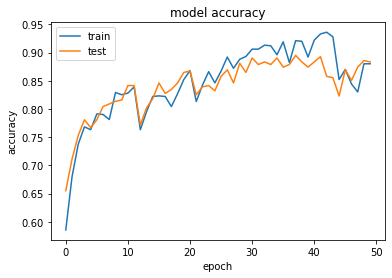

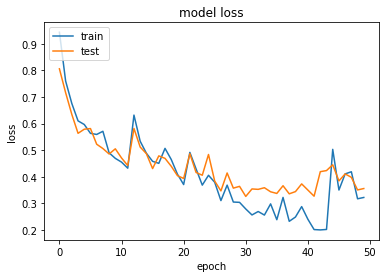

In [46]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [1]:
model.get_weights()

NameError: name 'model' is not defined